In [ ]:
!nvidia-smi

Sun Aug  8 13:47:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
# !pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 4.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=d586e9bbe43ea7fc4a2dca3f6643499af907808a774b672411c89b17ae2ba146
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
     |████████████████████████████████| 6.4 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 2.6 MB/s 
     |████████████████████████████████| 144 kB 7.9 MB/s 
     |████████████████████████████████| 130 kB 58.2 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 743 kB 56.6 MB/s 
     |████████████████████████████████| 722 kB 55.3 MB/s 
     |███

In [ ]:
!pip install albumentations==1.0.3

     |████████████████████████████████| 98 kB 3.7 MB/s 
     |████████████████████████████████| 37.1 MB 1.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import random
from collections import Counter, defaultdict
from itertools import chain

import ast
import cv2
# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.bbox_utils import convert_bbox_to_albumentations, convert_bbox_from_albumentations

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset, random_split
# from torch.cuda.amp import GradScaler, autocast

# import wandb

import torchvision
# from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import matplotlib

import os
import warnings
from datetime import datetime, timedelta
import time
import gc
import re
import yaml
import shutil
import json
from tqdm.notebook import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
from pprint import pprint
import copy
# from torchinfo import summary

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common libraries

from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 25)
pd.set_option('display.max_rows', 20)
# %load_ext line_profiler

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla V100-SXM2-16GB


In [ ]:
prepare_data = True
if os.path.exists('/content/data'):
    prepare_data = False

In [ ]:
if prepare_data:    
    from google.colab import files, drive

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
    
    # Then move kaggle.json into the folder where the API expects to find it.
    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    # !mkdir data && cd data && mkdir images && cd images && kaggle datasets download -d xhlulu/siim-covid19-resized-to-512px-png
    # !unzip /content/data/images/siim-covid19-resized-to-512px-png.zip -d /content/data/images
    !mkdir data && cd data && mkdir images && cd images && kaggle datasets download sunpnwt12/siim-covid19-train
    !unzip /content/data/images/siim-covid19-train.zip -d /content/data/images
    !git clone https://github.com/xingyizhou/CenterNet2.git
    !mv /content/data/images/siim-covid19-train/meta.csv /content/data

    drive.mount('/content/drive')
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/train_df.csv /content/data/train_df.csv
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/train_image_level.csv /content/data/train_image_level.csv
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/train_study_level.csv /content/data/train_study_level.csv
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/duplicates.csv /content/data/duplicates.csv

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/images/train_masked/train_masked/2c1d9b4830aa.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c297acf1d25.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c2cb3af5448.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c41f0b77b68.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c4e95472ebb.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c501267c8db.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c520dcf9515.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c61598e8b03.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c805bfe1155.jpg  
  inflating: /content/data/images/train_masked/train_masked/2ca1a13e2349.jpg  
  inflating: /content/data/images/train_masked/train_masked/2ca6fa018f86.jpg  
  inflating: /content/data/images/train_masked/train_masked/2cb791040cb1.jpg  
 

In [ ]:
config = {
    'batch_size': 4,
    'seed': 42,
    'num_classes': 1,
    'fold': 5,
    'image_size': 640,
    'num_workers': 4,
    'box_format': 'pascal'
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config['seed'])

In [ ]:
SAMP_SUB = '/content/data/sample_submission.csv'
TRAIN_IMAGE_LEVEL = '/content/data/train_image_level.csv'
TRAIN_STUDY_LEVEL = '/content/data/train_study_level.csv'
# TRAIN_PATH = '../input/siim-covid19-detection/train'
# TEST_PATH = '../input/siim-covid19-detection/test'


TRAIN_JPG = '/content/data/images/siim-covid19-train/train'
TEST_JPG = '/content/data/images/siim-covid19-train/test'
META = '/content/data/meta.csv'

TDF_PATH = '/content/data/train_df.csv'
# TRAIN_DFV2 = '/content/data/train_df_v2.csv'

DUPLICATES = '/content/drive/MyDrive/kaggle/siim-covid19-detection/pairs.csv'
# DUPLICATES = '/content/drive/MyDrive/kaggle/siim-covid19-detection/pairs.csv'

In [ ]:
duplicates_df = pd.read_csv(DUPLICATES)
# duplicates_images = []
# for idx, row in duplicates_df.iloc[:, 1:].iterrows():
#     duplicates_images.append(row.dropna().tolist())
# duplicates_images = pd.Series(list(zip(*duplicates_images))[0]).apply(lambda row: row[:-6])

duplicates_images = np.squeeze(duplicates_df['image2'].str.extract('.*/.*/.*/(.*).dcm').values)

In [ ]:
train_df = pd.read_csv(TDF_PATH)
study_lvl = pd.read_csv(TRAIN_STUDY_LEVEL)
image_lvl = pd.read_csv(TRAIN_IMAGE_LEVEL)
meta = pd.read_csv(META)

train_df['integer_label'] = np.argmax(train_df.iloc[:,4:8].values, axis=1)
train_df['ImageInstanceUID'] = train_df['id'].str.split('_').apply(lambda row: row[0])

train_jpg = pd.DataFrame(glob(f'{TRAIN_JPG}/*'), columns=['train_jpg'])
train_jpg['file_name'] = train_jpg.iloc[:,0].str.extract(f'{TRAIN_JPG}/(.*).jpg')

train_df = train_df.merge(train_jpg, left_on='ImageInstanceUID', right_on='file_name')

meta_train = meta[meta['split'] == 'train'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)
meta_test = meta[meta['split'] == 'test'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)

train_df = train_df.merge(meta_train, left_on='ImageInstanceUID', right_on='image_id')

box_format = config['box_format']
bboxes_list = []
for bbox, width, height in zip(train_df['boxes'], train_df['width'], train_df['height']):
    temp = []
    for i in range(8):
        try:
            box = ast.literal_eval(bbox)[i]

            width_ratio = config['image_size'] / width
            height_ratio = config['image_size'] / height

            x_min = box['x'] * height_ratio
            y_min = box['y'] * width_ratio
            x_width = box['width'] * height_ratio
            y_height = box['height'] * width_ratio
            box_coco = [x_min, y_min, x_width, y_height]

            album_format = convert_bbox_to_albumentations(box_coco, 'coco', config['image_size'], config['image_size'])

            if box_format == 'pascal':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                pascal_format = convert_bbox_from_albumentations(album_format, 'pascal_voc',
                                                               config['image_size'],
                                                               config['image_size'])

                x_min = pascal_format[0]
                y_min = pascal_format[1]
                x_max = pascal_format[2]
                y_max = pascal_format[3]

                box_pascal = np.clip([x_min, y_min, x_max, y_max], 0.0, config['image_size'])
                temp.append(box_pascal)
                
            if box_format == 'coco':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_width = box['width'] * height_ratio
                # y_height = box['height'] * width_ratio
                coco_format = convert_bbox_from_albumentations(album_format, 'coco',
                                                               config['image_size'],
                                                               config['image_size'])
                x_min = coco_format[0]
                y_min = coco_format[1]
                x_width = coco_format[2]
                y_height = coco_format[3]

                box_coco = [x_min, y_min, x_width, y_height]
                temp.append(box_coco)
            
            # [class x_center y_center width height] format
            # range of format is 0~1 optimized for yolov5
            if box_format == 'yolo':

                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                
                # #n normalize bbox with 512
                # x_center = ((x_min + x_max)/2) / config['image_size']
                # y_center = ((y_min + y_max)/2) / config['image_size']
                # b_width = (x_max - x_min) / config['image_size']
                # b_height = (y_max - y_min) / config['image_size']

                yolo_format = convert_bbox_from_albumentations(album_format, 'yolo',
                                                               config['image_size'],
                                                               config['image_size'])

                x_center = yolo_format[0]
                y_center = yolo_format[1]
                b_width = yolo_format[2]
                b_height = yolo_format[3]

                box_yolo = [x_center, y_center, b_width, b_height]
                temp.append(box_yolo)
            
        except IndexError:
            pass
        except ValueError:
            temp.append(np.nan)
    if box_format != 'yolo':
        if np.isnan(temp).all():
            temp = [[0.0, 0.0, 1.0, 1.0]]

    bboxes_list.append(temp)

bboxes_df = pd.DataFrame(bboxes_list, columns=[f'box_{i}' for i in range(8)])
train_df = pd.concat([train_df, bboxes_df], axis=1)

# drop weird data 
# not negative and no bbox

not_zeros_df = train_df[train_df['integer_label'] != 0]
drop_row = not_zeros_df[not_zeros_df['boxes'].isnull()].index.values
train_df = train_df.drop(drop_row)
train_df = train_df[~train_df['ImageInstanceUID'].isin(duplicates_images)].reset_index(drop=True)

np.concatenate(train_df[[f'box_{i}' for i in range(8)]]['box_0'].dropna().values)[np.concatenate(train_df[[f'box_{i}' for i in range(8)]]['box_0'].dropna().values, axis=0) < 0] = 0
train_df

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity,Path,Sex_F,...,file_name,image_id,width,height,box_0,box_1,box_2,box_3,box_4,box_5,box_6,box_7
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,../input/siim-covid19-detection/train/5776db0c...,0,...,000a312787f2,000a312787f2,3488,4256,"[118.68997894736842, 106.86795412844037, 273.0...","[337.73113984962407, 108.47803302752294, 502.3...",None,None,None,None,None,None
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,0,...,000c3a3f293f,000c3a3f293f,2320,2832,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,../input/siim-covid19-detection/train/9d514ce4...,1,...,0012ff7358bc,0012ff7358bc,2544,3056,"[141.86851518324607, 49.805438993710695, 323.6...","[375.4325947643979, 101.27106918238994, 504.65...",None,None,None,None,None,None
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1,../input/siim-covid19-detection/train/28dddc85...,1,...,001398f4ff4f,001398f4ff4f,3520,4280,"[408.07476635514024, 396.60605636363636, 549.8...",None,None,None,None,None,None,None
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,../input/siim-covid19-detection/train/dfd9fdd8...,0,...,001bd15d1891,001bd15d1891,2800,3408,"[117.03911361502348, 240.0, 251.123620657277, ...","[484.2378610328638, 228.26666742857142, 608.68...",None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,0,0,../input/siim-covid19-detection/train/7e6c6846...,1,...,ffcc6edd9445,ffcc6edd9445,4240,3480,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
5972,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,0,0,../input/siim-covid19-detection/train/8332bdad...,1,...,ffd91a2c4ca0,ffd91a2c4ca0,2800,3408,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
5973,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,3,1,../input/siim-covid19-detection/train/7eed9af0...,0,...,ffd9b6cf2961,ffd9b6cf2961,2388,3050,"[461.0907614426229, 225.41336281407035, 527.48...","[498.5447176393443, 490.6908274706867, 554.725...","[148.40697495081966, 193.52207973199327, 230.6...",None,None,None,None,None
5974,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2,1,../input/siim-covid19-detection/train/a0cb0b96...,0,...,ffdc682f7680,ffdc682f7680,3488,4256,"[410.4166661654135, 60.96521834862386, 635.416...","[151.25, 290.7664422018349, 250.83332781954886...",None,None,None,None,None,None


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=config['seed']):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
folds_df = train_df.copy()
seed_everything(config['seed'])
train_x = folds_df.index.values
train_y = folds_df.integer_label.values
groups = folds_df.image_id


for fold, (train_idx, valid_idx) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    folds_df.loc[folds_df.iloc[valid_idx].index, 'fold'] = fold

folds_df['fold'] = folds_df['fold'].astype(np.int)
folds_df.groupby(['fold', folds_df.integer_label]).size()

fold  integer_label
0     0                342
      1                568
      2                208
      3                 78
1     0                342
      1                568
      2                208
      3                 78
2     0                342
      1                568
      2                208
      3                 78
3     0                342
      1                567
      2                208
      3                 77
4     0                341
      1                567
      2                208
      3                 78
dtype: int64

In [ ]:
def copy_images(copy_from, df, fold=0, image_size=config['image_size']):
    directory = '/content/siim/'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    
    for idx, df in enumerate([train_df, valid_df]):
        if idx == 0: 
            sep_directory = os.path.join(directory, 'train')
            if not os.path.exists(sep_directory):
                os.makedirs(sep_directory)
        elif idx == 1:
            sep_directory = os.path.join(directory, 'val')
            if not os.path.exists(sep_directory):
                os.makedirs(sep_directory)
        
        df = df.sort_index()
        images_list = df['train_jpg'].tolist()
        for original_image_path in images_list:
            image_name = re.findall(f'{copy_from}/(.*).jpg', original_image_path)[0]
            target = os.path.join(sep_directory, f'{image_name}.jpg')
            image = cv2.imread(original_image_path, 0)
            image = cv2.resize(image, (image_size, image_size))
            cv2.imwrite(target, image)
            # shutil.copy(original_image_path, target)

In [ ]:
# !rm -rf /content/siim

In [ ]:
fold = 0

if not os.path.exists('/content/siim'):
    copy_images(TRAIN_JPG, folds_df, fold=fold)

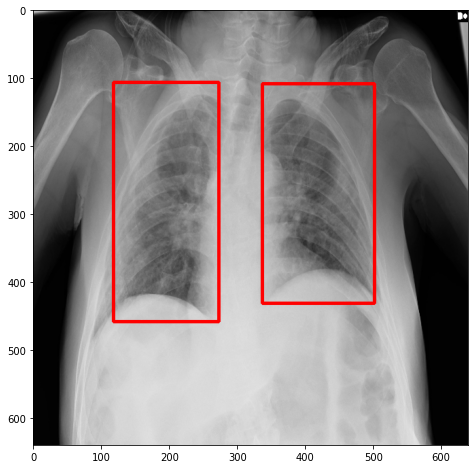

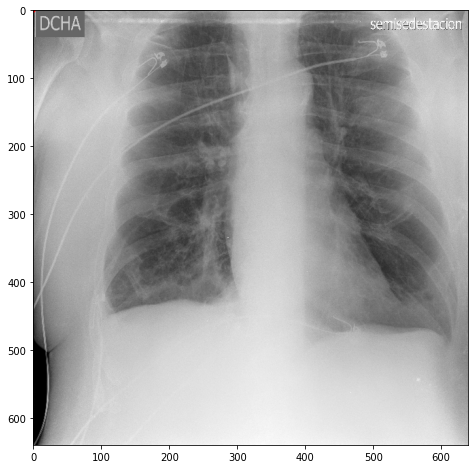

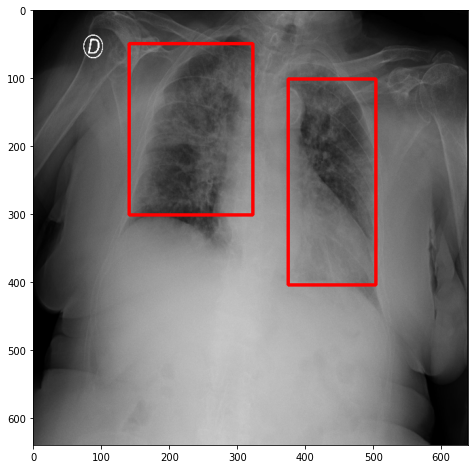

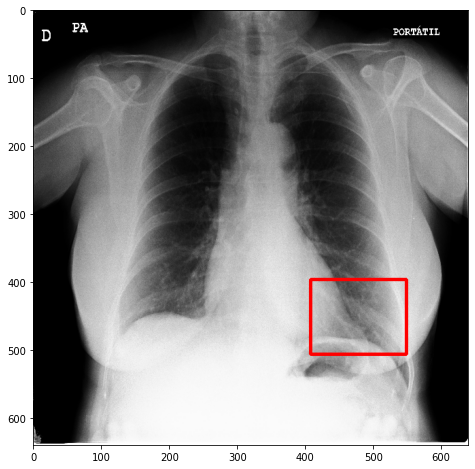

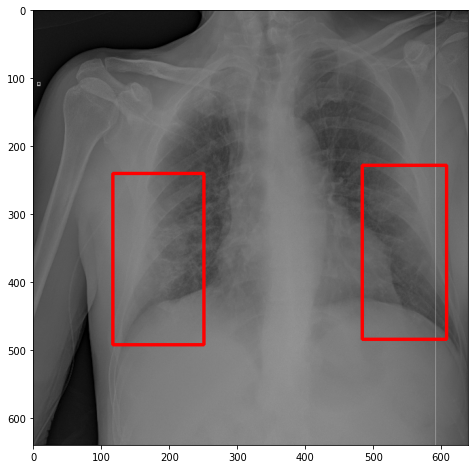

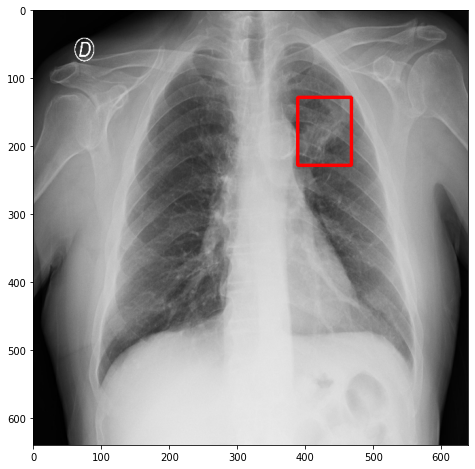

In [ ]:
for idx, row in folds_df.iterrows():
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    image_path = row.train_jpg
    image = cv2.imread(image_path)
    image = cv2.resize(image, (config['image_size'], config['image_size']))
    image_id = row.ImageInstanceUID
    bboxes = row[[f'box_{i}' for i in range(8)]].dropna().tolist()
    for bbox in bboxes:
        start = (int(bbox[0]), int(bbox[1]))
        end = (int(bbox[2]), int(bbox[3]))
        color = (255, 0, 0)
        thickness = 3
        cv2.rectangle(image, start, end, color, thickness)

    plt.imshow(image)
    plt.show()
    if idx == 5:
        break


In [ ]:
def get_siim_dict(df, fold, base_dir=''):
    dataset_dicts = []
    if base_dir == '/content/siim/train':
        df = df[df['fold'] != fold]
    else:
        df = df[df['fold'] == fold]
    for idx, row in df.iterrows():
        record = {}

        # record['filname'] = row.ImageInstanceUID + '.jpg'
        # file_name_list = glob(f'{base_dir}/*.jpg')
        record['file_name'] = os.path.join(base_dir, row.ImageInstanceUID + '.jpg')
        record['image_id'] = idx
        # record['height'] = row.height
        # record['width'] = row.width
        record['height'] = config['image_size']
        record['width'] = config['image_size']

        bboxes_list = row[[f'box_{i}' for i in range(8)]].dropna().values
        bboxes_list = np.stack(bboxes_list).tolist()
        opacity = row.Opacity
        # need to round up?
        objs = []
        for bbox in bboxes_list:
            if opacity == 1: 
                obj = {
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": 0,
                }
                objs.append(obj)
            else:
                continue
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

    # file_name
    # height
    # width
    # image_id
    # annotations
    #     bbox
    #     bbox_mode
    #     category_id


In [ ]:
train_image_path = '/content/siim/train'
valid_image_path = '/content/siim/val'

# folds_3_cls = folds_df[folds_df['integer_label'] > 0]

train_dict = get_siim_dict(folds_df, fold=fold, base_dir=train_image_path)
valid_dict = get_siim_dict(folds_df, fold=fold, base_dir=valid_image_path)

In [ ]:
pprint(train_dict[1])

{'annotations': [],
 'file_name': '/content/siim/train/000c3a3f293f.jpg',
 'height': 640,
 'image_id': 1,
 'width': 640}


In [ ]:
pprint(valid_dict[0])

{'annotations': [{'bbox': [408.07476635514024,
                           396.60605636363636,
                           549.8317936448598,
                           506.42423818181817],
                  'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                  'category_id': 0}],
 'file_name': '/content/siim/val/001398f4ff4f.jpg',
 'height': 640,
 'image_id': 3,
 'width': 640}


In [ ]:
print('Train image equal: ', len(train_dict) == len(glob(f'{train_image_path}/*.jpg')))
print('Valid image equal: ', len(valid_dict) == len(glob(f'{valid_image_path}/*.jpg')))

Train image equal:  True
Valid image equal:  True


In [ ]:
len(glob(f'{train_image_path}/*.jpg'))

4780

In [ ]:
len(train_dict)

4780

In [ ]:
things_classes = [
    'opacity'
]
# fold = 0 
dir = '/content/siim/'

# for data in ['train', 'val']:
DatasetCatalog.register(f'siim_{fold}_train',lambda: get_siim_dict(folds_df, fold, dir + 'train'))
MetadataCatalog.get(f'siim_{fold}_train').set(thing_classes=things_classes)

DatasetCatalog.register(f'siim_{fold}_val', lambda: get_siim_dict(folds_df, fold, dir + 'val'))
MetadataCatalog.get(f'siim_{fold}_val').set(thing_classes=things_classes)

siim_metadata = MetadataCatalog.get(f'siim_{fold}_train')

In [ ]:
class AlbumentationsMapper:
    """Mapper which uses `albumentations` augmentations"""
    def __init__(self, cfg, is_train: bool = True):
        # aug_kwargs = cfg.aug_kwargs
        # aug_list = [
        # ]
        # if is_train:
        #     aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])


        aug_list = [
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5, rotate_limit=10.0),
                A.OneOf([
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
                ], p=0.9),
                A.Affine(p=0.4, shear=(-10.0, 10.0)),
                A.OneOf([
                    A.Blur(blur_limit=3, p=1.0), 
                    A.MedianBlur(blur_limit=3, p=1.0),
                    A.MotionBlur(p=1)
                ], p=0.5),
                A.GaussNoise(p=0.5)
        ]
        self.transform = A.Compose(
            aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"])
        )
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        # aug_input = T.AugInput(image)
        # transforms = self.augmentations(aug_input)
        # image = aug_input.image

        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        # category_id = np.array([obj["category_id"] for obj in dataset_dict["annotations"]], dtype=np.int64)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
        image = transformed["image"]
        annos = []
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
        dataset_dict.pop("annotations", None)  # Remove unnecessary field.

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [ ]:
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(cfg, True), sampler=sampler
        )
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR,"inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

In [ ]:
import sys
sys.path.insert(0, '/content/CenterNet2/projects/CenterNet2/')
from centernet.config import add_centernet_config
# config_file = '/content/CenterNet2/projects/CenterNet2/configs/CenterNet2_R50_1x.yaml'
config_file = '/content/CenterNet2/projects/CenterNet2/configs/CenterNet2_R2-101-DCN-BiFPN_4x+4x_1560_ST.yaml'
cfg = get_cfg()
add_centernet_config(cfg)
cfg.merge_from_file(config_file)

WARNING [08/08 13:57:19 d2.config.compat]: Config '/content/CenterNet2/projects/CenterNet2/configs/CenterNet2_R2-101-DCN-BiFPN_4x+4x_1560_ST.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [ ]:
# cfg = get_cfg()
# config_name = "Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml"
# cfg.merge_from_file(model_zoo.get_config_file(config_name))
# cfg.MODEL.MASK_ON = False

cfg.DATASETS.TRAIN = (f'siim_{fold}_train',)
cfg.DATASETS.TEST = (f'siim_{fold}_val',)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/kaggle/siim-covid19-detection/CenterNet2_R2-101-DCN-BiFPN_4x+4x_1560_ST.pth'
# cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/kaggle/siim-covid19-detection/CenterNet2_DLA-BiFPN-P3_24x.pth'
cfg.TEST.EVAL_PERIOD = 1000
cfg.TEST.AUG.ENABLED = True
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.NESTEROV = True
cfg.SOLVER.WARMUP_ITERS = 600
cfg.SOLVER.MAX_ITER = 8000
cfg.SOLVER.CHECKPOINT_PERIOD = 2000
cfg.SOLVER.AMP.ENABLED = False

cfg.INPUT.TRAIN_SIZE = config['image_size']
cfg.INPUT.TEST_SIZE = config['image_size']
# cfg.SOLVER.STEPS = []

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)

In [ ]:
# !pip install wandb
# import wandb
# wandb.login(key="3b4a4f9e3a49edd10367fc27bad65a138866678d")
# wandb.init(
#     project="siim-covid19-detection",
#     name=f'f0_detectron2_x101',
#     group=f'detectron2_x101',
#     tags=["image", "detectron2"],
#     sync_tensorboard=True)

In [ ]:
# resume_dir = os.getcwd()+'/output/'
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[08/08 13:59:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): BiFPN(
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(num_features=32, eps=1e-05)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): FrozenBatchNorm2d(num_features=32, eps=1e-05)
          (5): ReLU(inplace=True)
          (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (bn1): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
      (res2): Sequential(
        (0): BottleneckBlock(
          (shortcut): Sequential(
            (0): AvgPool2d(kernel_size=1, stride=1, padding=0)
            (1): Conv2d(
              64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
              (norm): FrozenBatchNorm2d(num_f

Skip loading parameter 'roi_heads.box_predictor.0.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.2.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) 

[08/08 13:59:31 d2.engine.train_loop]: Starting training from iteration 0
[08/08 13:59:56 d2.utils.events]:  eta: 2:28:24  iter: 19  total_loss: 3.445  loss_cls_stage0: 0.7446  loss_box_reg_stage0: 0.04958  loss_cls_stage1: 0.673  loss_box_reg_stage1: 0.03742  loss_cls_stage2: 0.8406  loss_box_reg_stage2: 0.009044  loss_centernet_loc: 0.471  loss_centernet_agn_pos: 0.492  loss_centernet_agn_neg: 0.116  time: 1.1804  data_time: 0.0505  lr: 3.1471e-06  max_mem: 13278M
[08/08 14:00:15 d2.utils.events]:  eta: 1:58:45  iter: 39  total_loss: 3.261  loss_cls_stage0: 0.6833  loss_box_reg_stage0: 0.04804  loss_cls_stage1: 0.6215  loss_box_reg_stage1: 0.03186  loss_cls_stage2: 0.7715  loss_box_reg_stage2: 0.00839  loss_centernet_loc: 0.4539  loss_centernet_agn_pos: 0.4993  loss_centernet_agn_neg: 0.05609  time: 1.0655  data_time: 0.0228  lr: 6.4336e-06  max_mem: 13278M
[08/08 14:00:33 d2.utils.events]:  eta: 1:58:44  iter: 59  total_loss: 2.848  loss_cls_stage0: 0.5491  loss_box_reg_stage0: 0.06

KeyboardInterrupt: ignored

In [ ]:
save_name = f'model_final_f{fold}_CenterNet2_R2-101-DCN-BiFPN_new2'

In [ ]:
!cp '/content/output/CenterNet2/auto/model_final.pth' /content/drive/MyDrive/kaggle/siim-covid19-detection/detectron2_temp_model/{save_name}.pth

In [ ]:
cfg.MODEL.WEIGHTS = f'/content/drive/MyDrive/kaggle/siim-covid19-detection/detectron2_temp_model/{save_name}.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001
predictor = DefaultPredictor(cfg)

In [ ]:
cfg.MODEL.WEIGHTS

'/content/drive/MyDrive/kaggle/siim-covid19-detection/detectron2_temp_model/model_final_f0_CenterNet2_R2-101-DCN-BiFPN_new.pth'

In [ ]:
evaluator = COCOEvaluator(f"siim_{fold}_val", cfg, False, output_dir="/content/output")
val_loader = build_detection_test_loader(cfg, f"siim_{fold}_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

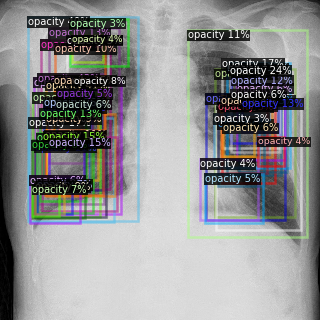

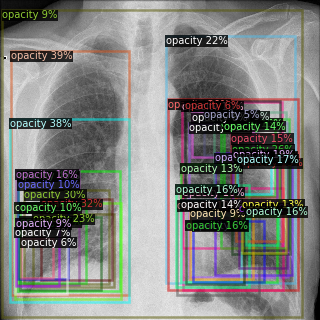

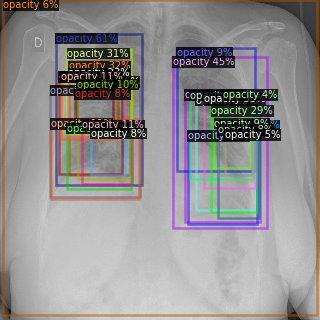

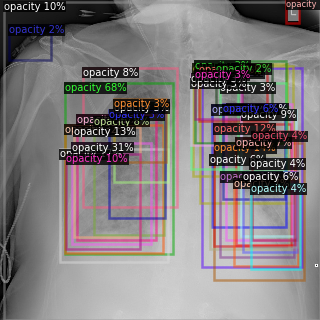

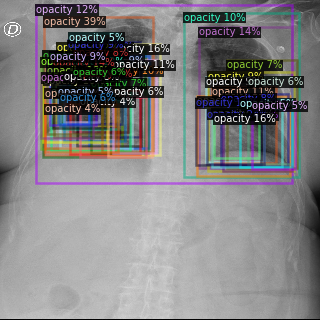

In [ ]:
for d in random.sample(valid_dict, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=siim_metadata, 
                   scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 170 kB 18.1 MB/s 
     |████████████████████████████████| 138 kB 18.7 MB/s 
     |████████████████████████████████| 133 kB 23.5 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 903 kB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=9015f746ba0de228d53bfd1e85b194e39b305aa95b7e9f40599f6c99b91e2b81
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4e221f6e4bec08ce9669e24bfd8d99622cd102f5a25daf26ae1400aa6c74d0cf
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
  Attempting uninstall: urlli

In [ ]:
os.environ["WANDB_API_KEY"] = '3b4a4f9e3a49edd10367fc27bad65a138866678d'
os.environ["WANDB_PROJECT"] = 'siim-covid19-detection'
# os.environ["WANDB_RUN_GROUP"] = 'detectron2_centernet2_BiFPN-exp'
# os.environ["WANDB_NAME"] = f'f{fold}_detectron2_centernet2_BiFPN'
# os.environ["WANDB_TAGS"] = "image"
!wandb login
!wandb sync /content/output/events.out.tfevents.1628354520.ba55217f1d07.64.0

wandb: Currently logged in as: sunpnwt (use `wandb login --relogin` to force relogin)
Found 1 tfevent files in /content/output
Syncing: https://wandb.ai/sunpnwt/uncategorized/runs/21ulqwvl ...
2021-08-07 20:39:34.003828: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
^C


In [ ]:
!kaggle datasets download -d sunpnwt12/detectron2-model

100% 3.78G/3.80G [01:34<00:00, 41.0MB/s]
100% 3.80G/3.80G [01:34<00:00, 43.3MB/s]


In [ ]:
outputs

{'instances': Instances(num_instances=100, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 96.3534,  61.4550, 301.6602, 285.3928],
         [423.8051, 201.9874, 523.8358, 317.6167],
         [415.7640, 172.0502, 566.7817, 326.1421],
         [122.9034,  85.7708, 236.9870, 263.3524],
         [109.3998, 162.9376, 247.7925, 279.0280],
         [389.2318,  51.1448, 602.0389, 350.3133],
         [220.2883,  85.4325, 312.7633, 275.2085],
         [141.6424, 141.7070, 289.9957, 283.4653],
         [ 94.5748, 124.7293, 206.8996, 262.4900],
         [186.3653,  37.8678, 325.8705, 291.5569],
         [462.8768, 111.9356, 572.7925, 298.3313],
         [432.8297, 239.9453, 574.2731, 324.4881],
         [489.6558, 175.9150, 576.5583, 303.8090],
         [ 85.2619, 183.6764, 197.5757, 272.3566],
         [ 45.8098,  29.2112, 336.5275, 356.8115],
         [397.8178, 139.1298, 524.2764, 309.6873],
         [ 64.5504, 107.7729, 240.0101, 303.2978],
         [500.2255, 126.3726, 

In [ ]:
!unzip /content/detectron2-model.zip -d /content/

Archive:  /content/detectron2-model.zip
  inflating: /content/centernet2/centernet2/DCN-r2-101-BiFPN/iter_log.txt  
  inflating: /content/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f0_centernet2_BiFPN_Haug.pth  
  inflating: /content/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f1_centernet2_BiFPN_Haug.pth  
  inflating: /content/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f2_centernet2_BiFPN_Haug.pth  
  inflating: /content/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f3_centernet2_BiFPN_Haug.pth  
  inflating: /content/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f4_centernet2_BiFPN_Haug.pth  
  inflating: /content/centernet2/centernet2/DCN-r2-101/model_final_f0_centernet2.pth  
  inflating: /content/centernet2/centernet2/DCN-r2-101/model_final_f0_centernet2_Haug.pth  
  inflating: /content/frcnn-x101/frcnn-x101/model_final_f0_frcnn-x101.pth  
  inflating: /content/frcnn-x101/frcnn-x101/model_final_f1_frcnn-x101.pth  


In [ ]:
import sys
sys.path.insert(0, '/content/CenterNet2/projects/CenterNet2/')
from centernet.config import add_centernet_config
# config_file = '/content/CenterNet2/projects/CenterNet2/configs/CenterNet2_R50_1x.yaml'
config_file = '/content/CenterNet2/projects/CenterNet2/configs/CenterNet2_R2-101-DCN-BiFPN_4x+4x_1560_ST.yaml'
cfg = get_cfg()
add_centernet_config(cfg)
cfg.merge_from_file(config_file)


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = '/content/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f0_centernet2_BiFPN_Haug.pth'

evaluator = COCOEvaluator(f"siim_{fold}_val", cfg, False, output_dir="/content/output")
val_loader = build_detection_test_loader(cfg, f"siim_{fold}_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [08/07 20:52:03 d2.config.compat]: Config '/content/CenterNet2/projects/CenterNet2/configs/CenterNet2_R2-101-DCN-BiFPN_4x+4x_1560_ST.yaml' has no VERSION. Assuming it to be compatible with latest v2.
WARNING [08/07 20:52:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/07 20:52:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/07 20:52:04 d2.data.common]: Serializing 1196 elements to byte tensors and concatenating them all ...
[08/07 20:52:04 d2.data.common]: Serialized dataset takes 0.28 MiB
[08/07 20:52:04 d2.evaluation.evaluator]: Start inference on 1196 batches
[08/07 20:52:07 d2.evaluation.evaluator]: Inference done 11/1196. Dataloading: 0.0010 s/iter. Inference: 0.2977 s/iter. Eval: 0.0002 s/iter. Total: 0.2990 s/iter. ETA=0:05:54
[08/07 20:52:12 d2.ev

OrderedDict([('bbox',
              {'AP': 14.024660979651562,
               'AP50': 43.36777081386177,
               'AP75': 5.550687890865459,
               'APl': 15.11010709240501,
               'APm': 1.1501927059294985,
               'APs': 0.0})])

In [ ]:
cfg.MODEL.WEIGHTS = '/content/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f1_centernet2_BiFPN_Haug.pth'

evaluator = COCOEvaluator(f"siim_{fold}_val", cfg, False, output_dir="/content/output")
val_loader = build_detection_test_loader(cfg, f"siim_{fold}_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [08/07 20:58:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/07 20:58:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/07 20:58:07 d2.data.common]: Serializing 1196 elements to byte tensors and concatenating them all ...
[08/07 20:58:07 d2.data.common]: Serialized dataset takes 0.28 MiB
[08/07 20:58:07 d2.evaluation.evaluator]: Start inference on 1196 batches
[08/07 20:58:11 d2.evaluation.evaluator]: Inference done 11/1196. Dataloading: 0.0013 s/iter. Inference: 0.2972 s/iter. Eval: 0.0003 s/iter. Total: 0.2988 s/iter. ETA=0:05:54
[08/07 20:58:16 d2.evaluation.evaluator]: Inference done 28/1196. Dataloading: 0.0015 s/iter. Inference: 0.2972 s/iter. Eval: 0.0002 s/iter. Total: 0.2991 s/iter. ETA=0:05:49
[08/07 20:58:21 d2.evaluation.evaluator]: Inference do

OrderedDict([('bbox',
              {'AP': 14.024660979651562,
               'AP50': 43.36777081386177,
               'AP75': 5.550687890865459,
               'APl': 15.11010709240501,
               'APm': 1.1501927059294985,
               'APs': 0.0})])

In [ ]:
cfg.MODEL.WEIGHTS = '/content/centernet2/centernet2/DCN-r2-101-BiFPN/model_final_f2_centernet2_BiFPN_Haug.pth'

evaluator = COCOEvaluator(f"siim_{fold}_val", cfg, False, output_dir="/content/output")
val_loader = build_detection_test_loader(cfg, f"siim_{fold}_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [08/07 21:04:07 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/07 21:04:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/07 21:04:08 d2.data.common]: Serializing 1196 elements to byte tensors and concatenating them all ...
[08/07 21:04:08 d2.data.common]: Serialized dataset takes 0.28 MiB
[08/07 21:04:08 d2.evaluation.evaluator]: Start inference on 1196 batches
[08/07 21:04:12 d2.evaluation.evaluator]: Inference done 11/1196. Dataloading: 0.0016 s/iter. Inference: 0.2979 s/iter. Eval: 0.0002 s/iter. Total: 0.2997 s/iter. ETA=0:05:55
[08/07 21:04:17 d2.evaluation.evaluator]: Inference done 28/1196. Dataloading: 0.0019 s/iter. Inference: 0.2973 s/iter. Eval: 0.0002 s/iter. Total: 0.2996 s/iter. ETA=0:05:49
[08/07 21:04:22 d2.evaluation.evaluator]: Inference do

OrderedDict([('bbox',
              {'AP': 14.024660979651562,
               'AP50': 43.36777081386177,
               'AP75': 5.550687890865459,
               'APl': 15.11010709240501,
               'APm': 1.1501927059294985,
               'APs': 0.0})])